In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import time
import glob
import torch
import os

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [0]:
#!git clone https://github.com/ialhashim/DenseDepth.git

In [0]:
#!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DenseDepth/nyu.h5

In [0]:
# need older version of tensor flow for running this model as it use old image apis..
import tensorflow as tf
if tf.__version__ != "1.15.0":
  !pip install 'tensorflow==1.15'

print(tf.__version__)

1.15.0


In [5]:
# switch to root working directory
cd /content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/DenseDepth/

/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/DenseDepth


In [6]:
import os
import glob
from tqdm import tqdm
import numpy as np
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

import zipfile
from io import BytesIO

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
from utils import predict, display_images
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

# Load model into GPU / CPU
model = load_model("nyu.h5", custom_objects=custom_objects, compile=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.





In [0]:
# initialize dataset locations
root_dataset = "/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/dataset"
inp_fg_bg_zipfile_name = f'{root_dataset}/fg_bg_images.zip'   # input images location
out_fg_bg_depth_zipfile_name = f'{root_dataset}/fg_bg_depth_images.zip'# depth map output location

In [0]:
'''
save depth mask with same name as input filename in the output zip file.
save only one channel in grey scale to save memory space. grey scale is sufficient as ground truth for depth prediction later
outputs: list fo predicted depth mask in same order as filelist
zf: output zipfile where depth mask images are added and stored
'''
def save_depth_mask(zf, outputs, filename_list):

    #plasma = plt.get_cmap('plasma')
    for idx in np.arange(len(outputs)):

        # rescaled betw min and max to highlight the objects in the images
        rescaled = outputs[idx][:,:,0]
        rescaled = rescaled - np.min(rescaled)
        rescaled = rescaled / np.max(rescaled)
        rescaled = np.uint8(rescaled*255)
        rescaled = cv2.bitwise_not(rescaled) # inverted image
        
        # for color depth mask
        #p_rescaled = plasma(rescaled)[:,:,:3]
        #p_rescaled = np.uint8(p_rescaled*255) #back to 0 to 255 scale for saving

        # get file name from input file path
        words = filename_list[idx].split("/")
        filename = words[len(words)-1]

        #cv2.imwrite("tmp_depth_color.jpg", np.uint8(p_rescaled*255)) # color image
        cv2.imwrite("tmp_depth_gray.jpg", rescaled) # gray scale image
        zf.write("tmp_depth_gray.jpg", filename)

def load_images_from_zip(zf, im_files):
    loaded_images = []
    for file in im_files:
        data = zf.read(file)
        dataEnc = BytesIO(data)
        im = Image.open(dataEnc)
        x = im.resize((480,480)) # upsampling
        x_np = np.clip(np.asarray(x, dtype=float) / 255, 0, 1)
        loaded_images.append(x_np)
    return np.stack(loaded_images, axis=0)

# get only image file names
def get_img_namelist(zf):
    image_list = []
    for name in in_zf.namelist():
      if '.jpg' in name or '.png' in name:
        image_list.append(name)

In [0]:
# open input and output package
in_zf = zipfile.ZipFile(inp_fg_bg_zipfile_name, 'r')
out_zf = zipfile.ZipFile(out_fg_bg_depth_zipfile_name, mode='a')

In [0]:
# have a look on input zipfile content
in_zf.namelist()[:5]

['fg014_bg003_01.jpg',
 'fg014flip_bg003_01.jpg',
 'fg014_bg003_02.jpg',
 'fg014flip_bg003_02.jpg',
 'fg014_bg003_03.jpg']

In [0]:
# filter only images files
img_list = [name for name in in_zf.namelist() if '.jpg' in name or '.png' in name]
print("number of fg_bg images: ", len(img_list))

number of fg_bg images:  400000


In [0]:
'''
challenges:
1. loading all 400k images at a time is not feasible due to memory limitation
2. processing of 400k images takes 5~6 hours and it is possible that notebook execution can terminated in between.
   we need to ensure that in next iteration it shall start from the palce it got stopped.

To solve above issues 
1. depth images are created in batches. for each foreground there are 4000 images. batch is processed at foreground level.
after every batch, memory are freed to ensure that it is avaiable for next iteration.
2. user shall provide the proper range of images for processing. 
3. old processed depth images are retained in out zip file. 
'''

f_start=1; f_end = 101 # choose the foreground image sequence for depth prediction
fg_bar = tqdm(np.arange(f_start, f_end))

for fidx in fg_bar:

  #It retrieves the list of files matching the specified pattern - all files of same foreground
  filelist = [name for name in img_list if f'fg{fidx:03d}' in name]

  # there are 4000 images for each foreground. run it in batch of 400
  b_size = 400
  b_cnt = 4000 // b_size

  for idx in np.arange(b_cnt):

    subfile_list = filelist[idx*b_size:(idx+1)*b_size]

    # loading all the image of specific foreground from zip file
    inputs = load_images_from_zip(in_zf, subfile_list)

    # get depth prediction
    outputs = predict(model, inputs, batch_size=64)

    # save grey scale depth prediction with same filenale as inputs under out_dir
    save_depth_mask(out_zf, outputs, subfile_list)

    # clear memory
    del inputs
    del outputs

  fg_bar.set_description(desc=f'processing image series fg{fidx:03d}*.jpg : {fidx*len(filelist)}/{len(fg_bar)*len(filelist)}')
  print("\n")

# num of depth masks created
print(f'\n\nnumber of fg_bg_depth images created: {len(out_zf.namelist())}')

# close the zip file resource
in_zf.close()
out_zf.close()

  0%|          | 0/100 [00:00<?, ?it/s]

processing image series fg001*.jpg : 4000/400000:   1%|          | 1/100 [03:05<5:05:31, 185.17s/it]

processing image series fg002*.jpg : 8000/400000:   2%|▏         | 2/100 [05:55<4:55:11, 180.73s/it]

processing image series fg003*.jpg : 12000/400000:   3%|▎         | 3/100 [08:55<4:51:34, 180.35s/it]

processing image series fg004*.jpg : 16000/400000:   4%|▍         | 4/100 [11:49<4:45:38, 178.53s/it]

processing image series fg005*.jpg : 20000/400000:   5%|▌         | 5/100 [14:43<4:40:40, 177.27s/it]

processing image series fg006*.jpg : 24000/400000:   6%|▌         | 6/100 [17:37<4:36:19, 176.38s/it]

processing image series fg007*.jpg : 28000/400000:   7%|▋         | 7/100 [20:32<4:32:43, 175.95s/it]

processing image series fg008*.jpg : 32000/400000:   8%|▊         | 8/100 [23:28<4:29:29, 175.76s/it]

processing image series fg009*.jpg : 36000/400000:   9%|▉         | 9/100 [26:23<4:26:18, 175.59s/it]

processing image series fg010*.jpg : 40000/400000:  10%|█         | 10/100 [29:18<4:23:17, 175.53s/it]

processing image series fg011*.jpg : 44000/400000:  11%|█         | 11/100 [32:14<4:20:29, 175.62s/it]

processing image series fg012*.jpg : 48000/400000:  12%|█▏        | 12/100 [35:11<4:18:04, 175.96s/it]

processing image series fg013*.jpg : 52000/400000:  13%|█▎        | 13/100 [38:07<4:15:05, 175.93s/it]

processing image series fg014*.jpg : 56000/400000:  14%|█▍        | 14/100 [41:04<4:12:41, 176.30s/it]

processing image series fg015*.jpg : 60000/400000:  15%|█▌        | 15/100 [44:00<4:09:32, 176.14s/it]

processing image series fg016*.jpg : 64000/400000:  16%|█▌        | 16/100 [46:56<4:06:44, 176.24s/it]

processing image series fg017*.jpg : 68000/400000:  17%|█▋        | 17/100 [49:53<4:03:55, 176.33s/it]

processing image series fg018*.jpg : 72000/400000:  18%|█▊        | 18/100 [52:48<4:00:40, 176.10s/it]

processing image series fg019*.jpg : 76000/400000:  19%|█▉        | 19/100 [55:44<3:57:43, 176.10s/it]

processing image series fg020*.jpg : 80000/400000:  20%|██        | 20/100 [58:40<3:54:39, 175.99s/it]

processing image series fg021*.jpg : 84000/400000:  21%|██        | 21/100 [1:01:36<3:51:50, 176.08s/it]

processing image series fg022*.jpg : 88000/400000:  22%|██▏       | 22/100 [1:04:32<3:48:50, 176.03s/it]

processing image series fg023*.jpg : 92000/400000:  23%|██▎       | 23/100 [1:07:27<3:45:34, 175.78s/it]

processing image series fg024*.jpg : 96000/400000:  24%|██▍       | 24/100 [1:10:22<3:42:11, 175.41s/it]

processing image series fg025*.jpg : 100000/400000:  25%|██▌       | 25/100 [1:13:17<3:39:06, 175.28s/it]

processing image series fg026*.jpg : 104000/400000:  26%|██▌       | 26/100 [1:16:12<3:36:04, 175.20s/it]

processing image series fg027*.jpg : 108000/400000:  27%|██▋       | 27/100 [1:19:07<3:33:11, 175.22s/it]

processing image series fg028*.jpg : 112000/400000:  28%|██▊       | 28/100 [1:22:02<3:30:07, 175.10s/it]

processing image series fg029*.jpg : 116000/400000:  29%|██▉       | 29/100 [1:24:58<3:27:34, 175.41s/it]

processing image series fg030*.jpg : 120000/400000:  30%|███       | 30/100 [1:27:53<3:24:34, 175.35s/it]

processing image series fg031*.jpg : 124000/400000:  31%|███       | 31/100 [1:30:48<3:21:31, 175.24s/it]

processing image series fg032*.jpg : 128000/400000:  32%|███▏      | 32/100 [1:33:43<3:18:28, 175.12s/it]

processing image series fg033*.jpg : 132000/400000:  33%|███▎      | 33/100 [1:36:38<3:15:34, 175.14s/it]

processing image series fg034*.jpg : 136000/400000:  34%|███▍      | 34/100 [1:39:32<3:12:17, 174.81s/it]

processing image series fg035*.jpg : 140000/400000:  35%|███▌      | 35/100 [1:42:27<3:09:10, 174.63s/it]

processing image series fg036*.jpg : 144000/400000:  36%|███▌      | 36/100 [1:45:22<3:06:22, 174.72s/it]

processing image series fg037*.jpg : 148000/400000:  37%|███▋      | 37/100 [1:48:16<3:03:20, 174.61s/it]

processing image series fg038*.jpg : 152000/400000:  38%|███▊      | 38/100 [1:51:10<3:00:23, 174.58s/it]

processing image series fg039*.jpg : 156000/400000:  39%|███▉      | 39/100 [1:54:05<2:57:31, 174.62s/it]

processing image series fg040*.jpg : 160000/400000:  40%|████      | 40/100 [1:56:59<2:54:27, 174.46s/it]

processing image series fg041*.jpg : 164000/400000:  41%|████      | 41/100 [1:59:54<2:51:29, 174.40s/it]

processing image series fg042*.jpg : 168000/400000:  42%|████▏     | 42/100 [2:02:47<2:48:26, 174.26s/it]

processing image series fg043*.jpg : 172000/400000:  43%|████▎     | 43/100 [2:05:42<2:45:38, 174.36s/it]

processing image series fg044*.jpg : 176000/400000:  44%|████▍     | 44/100 [2:08:36<2:42:43, 174.35s/it]

processing image series fg045*.jpg : 180000/400000:  45%|████▌     | 45/100 [2:11:31<2:39:54, 174.44s/it]

processing image series fg046*.jpg : 184000/400000:  46%|████▌     | 46/100 [2:14:26<2:37:11, 174.66s/it]

processing image series fg047*.jpg : 188000/400000:  47%|████▋     | 47/100 [2:17:21<2:34:23, 174.79s/it]

processing image series fg048*.jpg : 192000/400000:  48%|████▊     | 48/100 [2:20:17<2:31:39, 174.99s/it]

processing image series fg049*.jpg : 196000/400000:  49%|████▉     | 49/100 [2:23:12<2:28:48, 175.06s/it]

processing image series fg050*.jpg : 200000/400000:  50%|█████     | 50/100 [2:26:07<2:25:51, 175.03s/it]

processing image series fg051*.jpg : 204000/400000:  51%|█████     | 51/100 [2:29:03<2:23:13, 175.38s/it]

processing image series fg052*.jpg : 208000/400000:  52%|█████▏    | 52/100 [2:31:59<2:20:23, 175.49s/it]

processing image series fg053*.jpg : 212000/400000:  53%|█████▎    | 53/100 [2:34:55<2:17:33, 175.61s/it]

processing image series fg054*.jpg : 216000/400000:  54%|█████▍    | 54/100 [2:37:51<2:14:42, 175.70s/it]

processing image series fg055*.jpg : 220000/400000:  55%|█████▌    | 55/100 [2:40:46<2:11:43, 175.63s/it]

processing image series fg056*.jpg : 224000/400000:  56%|█████▌    | 56/100 [2:43:42<2:08:49, 175.67s/it]

processing image series fg057*.jpg : 228000/400000:  57%|█████▋    | 57/100 [2:46:37<2:05:49, 175.58s/it]

processing image series fg058*.jpg : 232000/400000:  58%|█████▊    | 58/100 [2:49:33<2:02:57, 175.66s/it]

processing image series fg059*.jpg : 236000/400000:  59%|█████▉    | 59/100 [2:52:29<1:59:59, 175.59s/it]

processing image series fg060*.jpg : 240000/400000:  60%|██████    | 60/100 [2:55:24<1:57:05, 175.64s/it]

processing image series fg061*.jpg : 244000/400000:  61%|██████    | 61/100 [2:58:20<1:54:06, 175.54s/it]

processing image series fg062*.jpg : 248000/400000:  62%|██████▏   | 62/100 [3:01:15<1:51:12, 175.60s/it]

processing image series fg063*.jpg : 252000/400000:  63%|██████▎   | 63/100 [3:04:11<1:48:15, 175.56s/it]

processing image series fg064*.jpg : 256000/400000:  64%|██████▍   | 64/100 [3:07:06<1:45:11, 175.31s/it]

processing image series fg065*.jpg : 260000/400000:  65%|██████▌   | 65/100 [3:10:01<1:42:18, 175.38s/it]

processing image series fg066*.jpg : 264000/400000:  66%|██████▌   | 66/100 [3:12:56<1:39:21, 175.33s/it]

processing image series fg067*.jpg : 268000/400000:  67%|██████▋   | 67/100 [3:15:52<1:36:27, 175.38s/it]

processing image series fg068*.jpg : 272000/400000:  68%|██████▊   | 68/100 [3:18:49<1:33:45, 175.79s/it]

processing image series fg069*.jpg : 276000/400000:  69%|██████▉   | 69/100 [3:21:45<1:30:57, 176.05s/it]

processing image series fg070*.jpg : 280000/400000:  70%|███████   | 70/100 [3:24:43<1:28:18, 176.62s/it]

processing image series fg071*.jpg : 284000/400000:  71%|███████   | 71/100 [3:27:40<1:25:24, 176.71s/it]

processing image series fg072*.jpg : 288000/400000:  72%|███████▏  | 72/100 [3:30:36<1:22:24, 176.57s/it]

processing image series fg073*.jpg : 292000/400000:  73%|███████▎  | 73/100 [3:33:33<1:19:24, 176.46s/it]

processing image series fg074*.jpg : 296000/400000:  74%|███████▍  | 74/100 [3:36:29<1:16:29, 176.54s/it]

processing image series fg075*.jpg : 300000/400000:  75%|███████▌  | 75/100 [3:39:25<1:13:27, 176.31s/it]

processing image series fg076*.jpg : 304000/400000:  76%|███████▌  | 76/100 [3:42:21<1:10:31, 176.33s/it]

processing image series fg077*.jpg : 308000/400000:  77%|███████▋  | 77/100 [3:45:18<1:07:36, 176.38s/it]

processing image series fg078*.jpg : 312000/400000:  78%|███████▊  | 78/100 [3:48:15<1:04:44, 176.56s/it]

processing image series fg079*.jpg : 316000/400000:  79%|███████▉  | 79/100 [3:51:12<1:01:53, 176.83s/it]

processing image series fg080*.jpg : 320000/400000:  80%|████████  | 80/100 [3:54:09<58:56, 176.82s/it]  

processing image series fg081*.jpg : 324000/400000:  81%|████████  | 81/100 [3:57:06<55:58, 176.76s/it]

processing image series fg082*.jpg : 328000/400000:  82%|████████▏ | 82/100 [4:00:02<53:01, 176.75s/it]

processing image series fg083*.jpg : 332000/400000:  83%|████████▎ | 83/100 [4:03:00<50:08, 176.96s/it]

processing image series fg084*.jpg : 336000/400000:  84%|████████▍ | 84/100 [4:05:57<47:11, 176.95s/it]

processing image series fg085*.jpg : 340000/400000:  85%|████████▌ | 85/100 [4:08:55<44:18, 177.22s/it]

processing image series fg086*.jpg : 344000/400000:  86%|████████▌ | 86/100 [4:11:52<41:19, 177.14s/it]

processing image series fg087*.jpg : 348000/400000:  87%|████████▋ | 87/100 [4:14:48<38:19, 176.86s/it]

processing image series fg088*.jpg : 352000/400000:  88%|████████▊ | 88/100 [4:17:44<35:20, 176.71s/it]

processing image series fg089*.jpg : 356000/400000:  89%|████████▉ | 89/100 [4:20:41<32:25, 176.87s/it]

processing image series fg090*.jpg : 360000/400000:  90%|█████████ | 90/100 [4:23:41<29:35, 177.60s/it]

processing image series fg091*.jpg : 364000/400000:  91%|█████████ | 91/100 [4:26:40<26:42, 178.01s/it]

processing image series fg092*.jpg : 368000/400000:  92%|█████████▏| 92/100 [4:29:38<23:45, 178.21s/it]

processing image series fg093*.jpg : 372000/400000:  93%|█████████▎| 93/100 [4:32:38<20:50, 178.67s/it]

processing image series fg094*.jpg : 376000/400000:  94%|█████████▍| 94/100 [4:35:36<17:50, 178.48s/it]

processing image series fg095*.jpg : 380000/400000:  95%|█████████▌| 95/100 [4:38:34<14:52, 178.42s/it]

processing image series fg096*.jpg : 384000/400000:  96%|█████████▌| 96/100 [4:41:32<11:52, 178.22s/it]

processing image series fg097*.jpg : 388000/400000:  97%|█████████▋| 97/100 [4:44:30<08:53, 177.98s/it]

processing image series fg098*.jpg : 392000/400000:  98%|█████████▊| 98/100 [4:47:27<05:55, 177.70s/it]

processing image series fg099*.jpg : 396000/400000:  99%|█████████▉| 99/100 [4:50:24<02:57, 177.63s/it]

processing image series fg100*.jpg : 400000/400000: 100%|██████████| 100/100 [4:53:21<00:00, 176.02s/it]






number of fg_bg_depth images created: 400000


### Verify all the dataset files are in place

In [0]:
cd /content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/dataset/

/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/dataset


In [0]:
!ls

bg_images		fg_bg_mask_images.zip  fg_mask_images
fg_bg_depth_images.zip	fg_images
fg_bg_images.zip	fg_images_powerpoint


### Depth result visualization

In [0]:
root_dataset = "/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/dataset"
inp_fg_bg_zipfile_name = f'{root_dataset}/fg_bg_images.zip'   # input images location
out_fg_bg_depth_zipfile_name = f'{root_dataset}/fg_bg_depth_images.zip'# depth map output location

In [0]:
def read_image_from_zip(zf, filename):
    data = zf.read(filename)
    dataEnc = BytesIO(data)
    img = Image.open(dataEnc)
    return img
		
def load_images_from_zip(zf_fb, zf_depth, im_files):
    fb_images = []
    depth_images = []
    for file in im_files:
      # fg_bg images
      fg_img = read_image_from_zip(zf_fb, file)
      fb_images.append(fg_img)

      # depth images
      depth_img = read_image_from_zip(zf_depth, file)
      depth_images.append(depth_img)

    #return np.stack(fb_images, axis=0), np.stack(depth_images, axis=0)
    return fb_images, depth_images

In [17]:
# filename for 10 different foreground and background images
randnums= np.random.randint(1,101,10)
filenames = [f'fg{idx:03d}_bg{idx:03d}_01.jpg' for idx in randnums]
filenames

['fg056_bg056_01.jpg',
 'fg025_bg025_01.jpg',
 'fg050_bg050_01.jpg',
 'fg041_bg041_01.jpg',
 'fg041_bg041_01.jpg',
 'fg012_bg012_01.jpg',
 'fg056_bg056_01.jpg',
 'fg082_bg082_01.jpg',
 'fg064_bg064_01.jpg',
 'fg048_bg048_01.jpg']

In [0]:
# get zip resources
zf_fb = zipfile.ZipFile(inp_fg_bg_zipfile_name, 'r')
zf_depth = zipfile.ZipFile(out_fg_bg_depth_zipfile_name, 'r')

fb_data, depth_data = load_images_from_zip(zf_fb, zf_depth, filenames)

# close the zip file resource
zf_fb.close()
zf_depth.close()

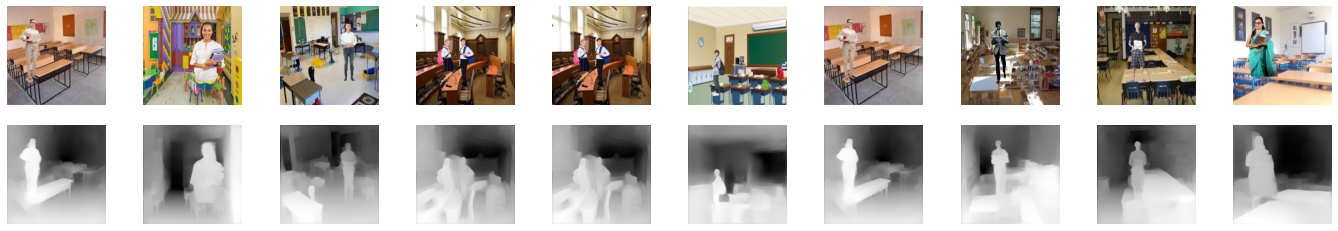

In [19]:
plt.figure(figsize=(24,4)) #
for i in np.arange(10):
    plt.subplot(2,10,i+1),plt.imshow(fb_data[i])
    plt.axis('off')

for i in np.arange(10):
    plt.subplot(2,10, i+11),plt.imshow(depth_data[i].convert('LA'))
    plt.axis('off')

plt.savefig("depth_mask_result.jpg")
plt.show()